In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [17]:
import numpy as np
import math
import cv2
import matplotlib.pylab as plt

import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

from glob import glob

In [3]:
list_image = sorted(glob('./data/train/input/img/*.png'))
list_label = sorted(glob('./data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

IMAGE_SHAPE = (80, 120)
data_root = './data/train/input'
label_root = './data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


In [4]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [5]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.49583334 0.375     ]
(80, 120, 3) [0.         0.         1.         1.         0.04405738 0.35625   ]


<ipython-input-4-2841512545d5>:14: RuntimeWarning: Mean of empty slice.
  lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-2841512545d5>:15: RuntimeWarning: Mean of empty slice.
  rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]


In [6]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [8]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [11]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 20160 32 630 -> 데이터를 batch_size 의 배수로 준비해 주세요.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


<ipython-input-4-2841512545d5>:14: RuntimeWarning: Mean of empty slice.
  lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
<ipython-input-4-2841512545d5>:15: RuntimeWarning: Mean of empty slice.
  rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]


741/741 [==============================] - 20s 27ms/step - loss: 0.0198 - mae: 0.0691 - lr: 5.0000e-04
Epoch 2/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0144 - mae: 0.0565 - lr: 2.5000e-04
Epoch 3/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0138 - mae: 0.0547 - lr: 2.5000e-04
Epoch 4/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0134 - mae: 0.0536 - lr: 1.2500e-04
Epoch 5/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0132 - mae: 0.0531 - lr: 1.2500e-04
Epoch 6/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0130 - mae: 0.0525 - lr: 6.2500e-05
Epoch 7/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0130 - mae: 0.0525 - lr: 6.2500e-05
Epoch 8/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0129 - mae: 0.0522 - lr: 3.1250e-05
Epoch 9/10
741/741 [==============================] - 15s 20ms/step - loss: 0.0128 - mae: 0.0521 - 

In [12]:
IMAGE_SHAPE = (80, 120)
val_data_root = './data/val/input'
val_label_root = './data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [13]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
<ipython-input-4-2841512545d5>:14: RuntimeWarning: Mean of empty slice.
  lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
<ipython-input-4-2841512545d5>:15: RuntimeWarning: Mean of empty slice.
  rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]


0.012655079364776611 0.05115162581205368


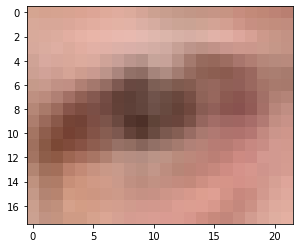

In [18]:
# img test
img = cv2.imread('./data/val/input/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[6.14582375e-02 2.46210415e-02]
  [1.19789055e+02 7.98591614e+01]
  [5.19008598e+01 2.86067181e+01]]]


[0. 0.]
[120.  80.]
[52. 29.]


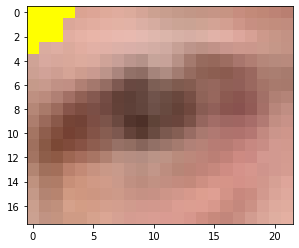

In [20]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()